In [126]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score


from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Options

In [132]:
debug = False
if (debug):
    num_data = 1000
else:
    num_data = 100000

# Setup Singletons

In [133]:
language = 'english'

stemmer = SnowballStemmer(language)
stopWords = set(stopwords.words(language))

# Retrieve Data - SLOW PROCESS - ONLY RUN ONCE

In [4]:
# read the entire file into a python array
with open('data/yelp_academic_dataset_review.json', 'rb') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)





### Filter columns so we just have text and stars

In [136]:
sample_data_df = data_df.sample(n = num_data)

print(list(data_df.columns.values))

filtered_data_df = sample_data_df[['stars', 'text']]

[u'business_id', u'date', u'review_id', u'stars', u'text', u'type', u'user_id', u'votes']


In [137]:
sentences = filtered_data_df['text']
result = filtered_data_df['stars']

vectorizer = CountVectorizer(analyzer = 'word', max_features=num_data / 10)
tfidf = TfidfTransformer(norm='l1')

In [138]:
def processWords(words, stem):
    
    words = [word for word in words if not word in stopWords]
    if (stem):
        words = [str(stemmer.stem(word)) for word in words]
    return words

def processSentence(sentence, stem):
    #print('--------------------------------------------------------------')
    #print(sentence)
    sentence = re.sub("[^a-zA-Z]", " " , sentence)
    
    #print('-------------------------------')
    #print(sentence)
    
    words = sentence.split()
    words = processWords(words, stem)
    
    processedSentence = ' '.join(words)
    #print('---------remove stop words and stem----------')
    #print(processedSentence)
    
    return processedSentence



# Function which we can call to transform a sentence to vector

In [139]:
def sentenceToVector(sentences, train = False, stem = True):

    print('This is length of data: ' +  str(len(sentences)))
    processedSentences = [0]*(len(sentences))

    for index, sentence in np.ndenumerate(sentences):
        index = index[0]

        processedSentences[index] = processSentence(sentence, stem)

    if (train):
        vectorizer.fit(processedSentences)
    
    print('test')
    vectorized_sentences = vectorizer.transform(processedSentences).toarray()

    if (train):
        tfidf.fit(vectorized_sentences)
        
    tfidf_sentences = tfidf.transform(vectorized_sentences).toarray()
    return tfidf_sentences

vectorized_sentences = sentenceToVector(sentences, True, False)
print(vectorized_sentences)
print(len(vectorizer.get_feature_names()))


This is length of data: 100000
test
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
10000


# set up X and Y

In [140]:
X, y = vectorized_sentences, result

In [111]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Learning Curve

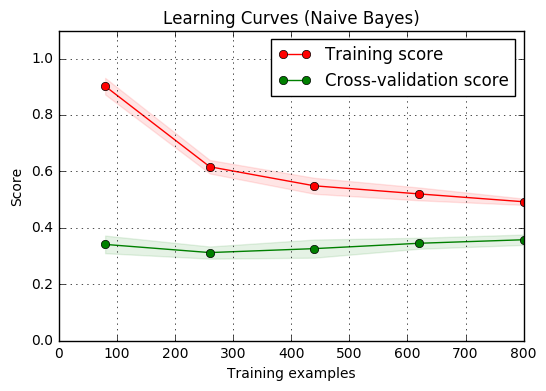

In [112]:
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0, 1.1), cv=cv, n_jobs=1)

plt.show()

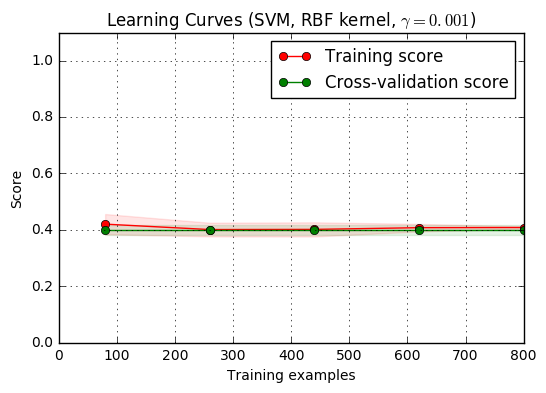

In [113]:
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(C=1, gamma = 0.3)
plot_learning_curve(estimator, title, X, y, (0, 1.1), cv=cv, n_jobs=1)

plt.show()

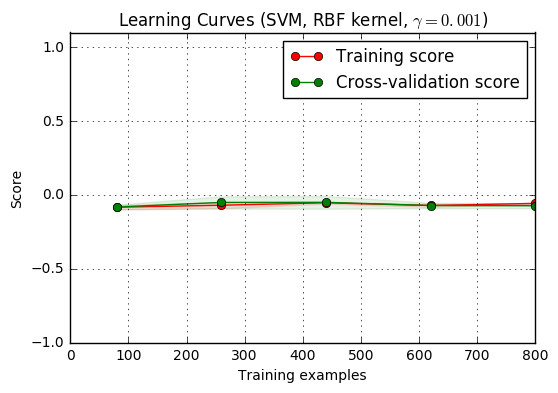

In [114]:
title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
estimator = SVR()
plot_learning_curve(estimator, title, X, y, (-1, 1.1), cv=cv, n_jobs=1)

plt.show()

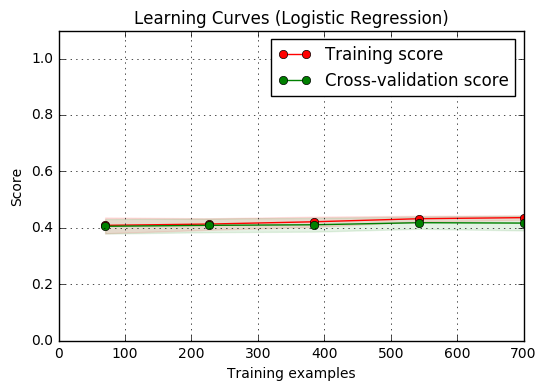

In [115]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
estimator = LogisticRegression(C = 1, solver= 'newton-cg', multi_class = 'multinomial')
plot_learning_curve(estimator, title, X, y, cv=cv, ylim=(0, 1.1), n_jobs=1)

plt.show()

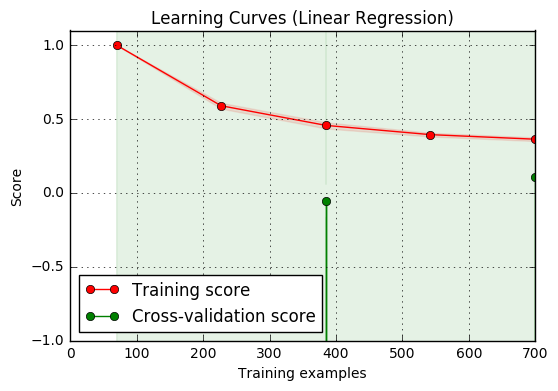

In [119]:
from sklearn.linear_model import LinearRegression

title = "Learning Curves (Linear Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
estimator = LinearRegression(n_jobs=2)
plot_learning_curve(estimator, title, X, y, cv=cv, ylim=(-1, 1.1), n_jobs=1)

plt.show()

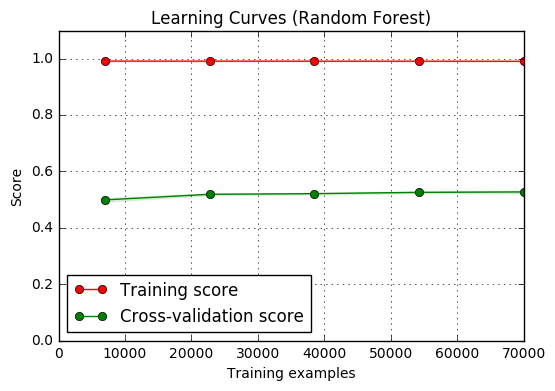

In [143]:
from sklearn.ensemble import RandomForestClassifier

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, cv=cv, ylim=(0, 1.1), n_jobs=1)

plt.show()

# ML 

### Pick Model

In [141]:
#estimator = LogisticRegression(C = 1, solver= 'newton-cg', multi_class = 'multinomial')
#estimator = SVC(C=1, gamma = 0.3)
#estimator = LinearRegression(n_jobs=2)
estimator = RandomForestClassifier()

### view score

In [144]:
cross_val_score(estimator, X, y, scoring='accuracy')

array([ 0.52854357,  0.53089938,  0.52881702])

### train data

In [147]:
estimator.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Test

In [148]:
test_sentences = ['Bad', 'Tastes like my barf', '', 'Mediocore', 'Okay', 'Good', 'Great']

print(test_sentences)

#print(sentences)


vectorized_test_sentences = sentenceToVector(test_sentences)
results = estimator.predict(vectorized_test_sentences)

print(results)

'''
for result in results:
    if (result != 5):
        print('test')
print(results)
'''


['Bad', 'Tastes like my barf', '', 'Mediocore', 'Okay', 'Good', 'Great']
This is length of data: 7
test
[1 5 5 5 3 4 5]


"\nfor result in results:\n    if (result != 5):\n        print('test')\nprint(results)\n"